In [127]:
_input_path = analysis_dir / "combined_evidence_filter.json"
with _input_path as _f:
    combined_evidence_filter = json.load(_f)

In [128]:
filter_type = [
    "asq_0.99",
    "asq_0.95",
    "asq_0.9",
    "asq_0.8",
    "asq_default",
    "epigraphdb",
]

----

In [ ]:
# reformat evidence into individual score df
def make_individual_score_df(evidence):
    TODO

----

In [117]:
evidence_df = (
    py_.chain(combined_evidence_filter_asq)
    .filter(lambda e: e["threshold"] == "default")
    .map(lambda e: e["evidence"])
    .flatten()
    .apply(pd.DataFrame)
    .value()
)
evidence_df

,doi,subject_term,object_term,pred_term,assoc_evidence,triple_evidence
0,10.1101/19001719,Antihypertensive Agents,Mood Disorders,TREATS,"{'supporting': [], 'contradictory_directional_...",{'supporting': [{'triple_id': 'C0003364:TREATS...
1,10.1101/19006189,Mental disorders,Diabetes,COEXISTS_WITH,{'supporting': [{'subject_id': 'ukb-d-KRA_PSY_...,{'supporting': [{'triple_id': 'C0026650:COEXIS...
2,10.1101/2019.12.11.19014472,Urate,Blood Pressure,AFFECTS,{'supporting': [{'subject_id': 'ukb-d-30880_ir...,"{'supporting': [], 'contradictory': []}"
3,10.1101/2020.01.03.19015602,Heart Diseases,Neoplasm Metastasis,COEXISTS_WITH,"{'supporting': [{'subject_id': 'ukb-d-I9_CHD',...",{'supporting': [{'triple_id': 'C0018801:COEXIS...
4,10.1101/2020.01.03.19015602,Disease,Left ventricular noncompaction cardiomyopathy,COEXISTS_WITH,"{'supporting': [], 'contradictory_undirectiona...",{'supporting': [{'triple_id': 'C0012634:COEXIS...
...,...,...,...,...,...,...
408,10.1101/2021.12.13.21267749,Age,"Diabetes Mellitus, Non-Insulin-Dependent",ASSOCIATED_WITH,"{'supporting': [{'subject_id': 'ieu-a-1004', '...",{'supporting': []}
409,10.1101/2021.12.17.21267964,Zinc,"Diabetes Mellitus, Non-Insulin-Dependent",TREATS,"{'supporting': [], 'contradictory_directional_...",{'supporting': [{'triple_id': 'C0043481:TREATS...
410,10.1101/2021.12.21.21267285,Pregnancy,"Lupus Erythematosus, Systemic",ASSOCIATED_WITH,"{'supporting': [], 'contradictory_undirectiona...",{'supporting': []}
411,10.1101/2021.12.23.21268279,Dyspnea,Hypertensive disease,COEXISTS_WITH,"{'supporting': [], 'contradictory_undirectiona...",{'supporting': [{'triple_id': 'C0013405:COEXIS...


In [118]:
individual_scores_df = evidence_df[
    ["pred_term", "assoc_evidence", "triple_evidence"]
].assign(
    evidence_count=lambda df: df.apply(
        lambda row: py_.chain(
            {
                "assoc": row["assoc_evidence"],
                "triple": row["triple_evidence"],
            }
        )
        .map(
            lambda v, k: [
                {
                    "evidence_type": EVIDENCE_LABELS[_k],
                    "strength_score": (
                        ([_["triple_score"] for _ in _v])
                        if k == "triple"
                        else ([_["assoc_score"] for _ in _v])
                    ),
                    "mapping_score": ([_["mapping_score"] for _ in _v]),
                    "evidence_score": ([_["evidence_score"] for _ in _v]),
                    "pred_term": row["pred_term"],
                    "evidence_group": k,
                }
                for _k, _v in v.items()
            ]
        )
        .reduce(lambda a, b: a + b)
        .apply(pd.DataFrame)
        .value(),
        axis=1,
    )
)
individual_scores_df = (
    py_.chain(
        pd.concat(individual_scores_df["evidence_count"].tolist())
        .assign(
            pred_group=lambda df: df["pred_term"].apply(
                lambda x: epigraphdb.PRED_DIRECTIONAL_MAPPING[x]
            )
        )
        .to_dict(orient="records")
    )
    .map(
        lambda items: [
            {
                "evidence_type": items["evidence_type"],
                "pred_term": items["pred_term"],
                "evidence_group": items["evidence_group"],
                "evidence_score": items["evidence_score"][idx],
                "strength_score": items["strength_score"][idx],
                "mapping_score": items["mapping_score"][idx],
            }
            for idx, _ in enumerate(items["evidence_score"])
        ]
    )
    .flatten()
    .apply(pd.DataFrame)
    .value()
)
print(individual_scores_df.info())
individual_scores_df[:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31910 entries, 0 to 31909
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   evidence_type   31910 non-null  object 
 1   pred_term       31910 non-null  object 
 2   evidence_group  31910 non-null  object 
 3   evidence_score  31910 non-null  float64
 4   strength_score  31910 non-null  float64
 5   mapping_score   31910 non-null  float64
dtypes: float64(3), object(3)
memory usage: 1.5+ MB
None


,evidence_type,pred_term,evidence_group,evidence_score,strength_score,mapping_score
0,Insufficient (directional),TREATS,assoc,0.618706,1.360090,0.454901
1,Supporting,TREATS,triple,0.842158,1.000000,0.842158
2,Supporting,TREATS,triple,1.067562,1.477121,0.722732
3,Supporting,TREATS,triple,1.612455,2.278754,0.707604
4,Supporting,TREATS,triple,1.609770,2.301030,0.699587


In [119]:
individual_scores_df.groupby(["evidence_group", "evidence_type"]).size()

evidence_group  evidence_type                 
assoc           Additional (directional)           1400
                Insufficient (directional)         5982
                Insufficient (non-directional)    12761
                Reversal                            908
                Supporting                         6420
triple          Reversal                            480
                Supporting                         3959
dtype: int64

In [120]:
# TODO n = min(500, n_sample)
_N_SAMPLE = 500
plot_data = (
    individual_scores_df.groupby(["evidence_group", "evidence_type"])
    .apply(
        lambda grouped_df: (
            grouped_df
            if len(grouped_df) < _N_SAMPLE
            else grouped_df.sample(n=_N_SAMPLE, random_state=42)
        )
    )
    .melt(
        value_vars=["evidence_score", "strength_score", "mapping_score"],
        id_vars=["evidence_type", "pred_term", "evidence_group"],
        var_name="score_type",
        value_name="score",
    )
    .assign(
        pred_group=lambda df: df["pred_term"].apply(
            lambda x: epigraphdb.PRED_DIRECTIONAL_MAPPING[x]
        ),
        evidence_type=lambda df: df["evidence_type"].apply(
            lambda x: x.split(" ")[0].strip()
        ),
    )
    .assign(
        pred_group=lambda df: df["pred_group"].apply(
            lambda x: "non-directional" if x == "undirectional" else x
        )
    )
)

plot_data

,evidence_type,pred_term,evidence_group,score_type,score,pred_group
0,Additional,CAUSES,assoc,evidence_score,1.078155,directional
1,Additional,CAUSES,assoc,evidence_score,1.172033,directional
2,Additional,AFFECTS,assoc,evidence_score,0.495514,directional
3,Additional,CAUSES,assoc,evidence_score,0.955164,directional
4,Additional,AFFECTS,assoc,evidence_score,0.833582,directional
...,...,...,...,...,...,...
10435,Supporting,COEXISTS_WITH,triple,mapping_score,0.547903,non-directional
10436,Supporting,ASSOCIATED_WITH,triple,mapping_score,0.893026,non-directional
10437,Supporting,COEXISTS_WITH,triple,mapping_score,0.622702,non-directional
10438,Supporting,CAUSES,triple,mapping_score,0.672710,directional


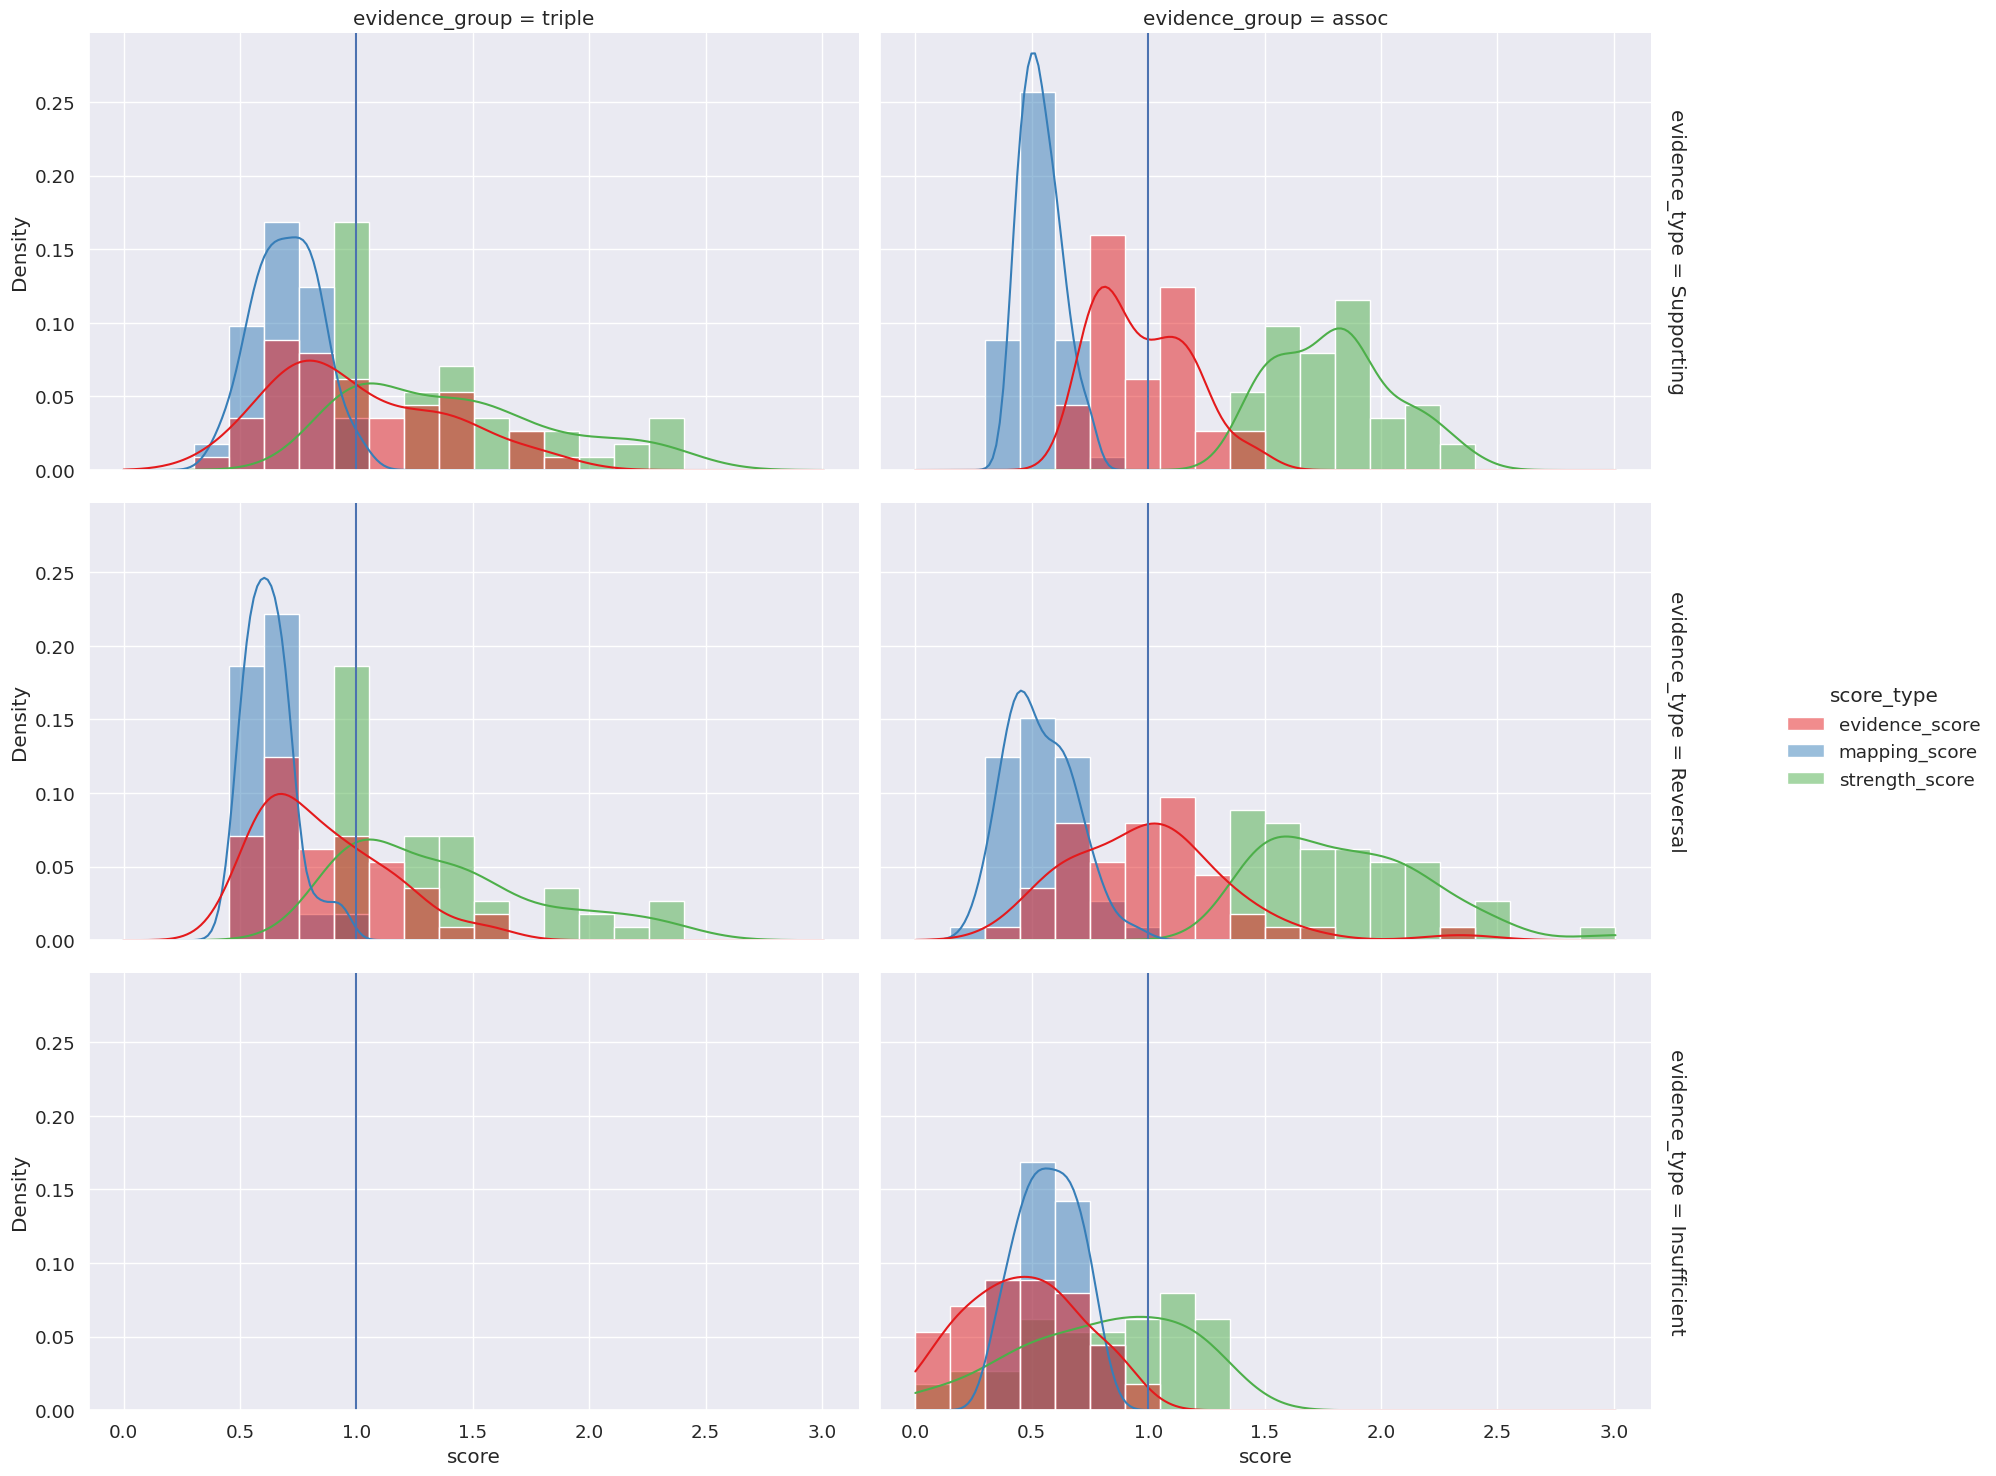

In [121]:
_N_SAMPLE = 50

sns.set(font_scale=1.2)
plot = sns.displot(
    data=plot_data[
        plot_data["evidence_type"].isin(["Supporting", "Reversal", "Insufficient"])
    ]
    .groupby(["score_type", "evidence_type", "evidence_group"])
    .apply(
        lambda grouped_df: (
            grouped_df
            if len(grouped_df) < _N_SAMPLE
            else grouped_df.sample(n=_N_SAMPLE, random_state=42)
        )
    ),
    kde=True,
    stat="density",
    x="score",
    col="evidence_group",
    col_order=[
        "triple",
        "assoc",
    ],
    row="evidence_type",
    row_order=[
        "Supporting",
        "Reversal",
        "Insufficient",
    ],
    hue="score_type",
    hue_order=[
        "evidence_score",
        "mapping_score",
        "strength_score",
    ],
    palette="Set1",
    fill=True,
    alpha=0.5,
    aspect=1.8,
    facet_kws={"sharex": True, "sharey": True, "margin_titles": True},
)

axes = [__ for _ in plot.axes for __ in _]
[_.axvline(1) for _ in axes]

plt.show()